<a target="_blank" href="https://colab.research.google.com/github/Sebelino/DD2424-project/blob/main/e1_sebastian.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%load_ext autoreload
%autoreload 2

import os
import socket

repo_name = "DD2424-project"
dep_filename = "download_dataset.py"
cwd = os.getcwd()
hostname = socket.gethostname()

print(f"Host: {hostname}")
print(f"You are here: {cwd}")

if os.path.exists(dep_filename):
    print(f"{dep_filename} is in your current directory. Assuming you are in the root of the repository.")
elif not os.path.exists(repo_name):
    print(f"Cloning repo and fetching {dep_filename}...")
    !git clone https://github.com/Sebelino/DD2424-project
    !cp DD2424-project/download_dataset.py .
else:
    !git -C DD2424-project pull --rebase
    !cp DD2424-project/download_dataset.py .

Host: deeplearning-vm
You are here: /home/sebelino/pycharm_deployment
download_dataset.py is in your current directory. Assuming you are in the root of the repository.


# Train model

Training with params:
{
  "seed": 42,
  "batch_size": 32,
  "architecture": "resnet50",
  "optimizer": {
    "learning_rate": 0.01,
    "weight_decay": 0.0001,
    "momentum": 0.9,
    "name": "nag"
  },
  "n_epochs": 10,
  "freeze_layers": true,
  "unfreezing_epochs": [3, 6],
  "validation_freq": 1
}
Train/Val size: 2944:736, Iterations per epoch: 92
GPU acceleration enabled: Yes 🚀


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [1/10], Loss: 1.6689, Train Acc: 71.47%, Val Acc: 88.32%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [2/10], Loss: 0.4733, Train Acc: 92.32%, Val Acc: 91.03%
Unfroze layer4 at epoch 3


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [3/10], Loss: 0.2506, Train Acc: 93.10%, Val Acc: 91.71%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [4/10], Loss: 0.0763, Train Acc: 98.47%, Val Acc: 91.98%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [5/10], Loss: 0.0431, Train Acc: 99.25%, Val Acc: 93.61%
Unfroze layer3 at epoch 6


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [6/10], Loss: 0.0310, Train Acc: 99.42%, Val Acc: 93.48%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [7/10], Loss: 0.0195, Train Acc: 99.63%, Val Acc: 94.29%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [8/10], Loss: 0.0107, Train Acc: 99.93%, Val Acc: 94.84%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [9/10], Loss: 0.0089, Train Acc: 99.90%, Val Acc: 94.57%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [10/10], Loss: 0.0074, Train Acc: 99.90%, Val Acc: 95.24%
Training result:
{
  "training_losses": [1.6689337611846302, 0.47329614408638165, 0.25059353301058646, 0.07627233775818477, 0.043067703486683415, 0.03103300376349817, 0.019521054802917995, 0.010683025366312864, 0.008937175521050054, 0.007392493995923914],
  "training_accuracies": [0.7146739130434783, 0.923233695652174, 0.931046195652174, 0.9847146739130435, 0.9925271739130435, 0.9942255434782609, 0.9962635869565217, 0.9993206521739131, 0.9989809782608695, 0.9989809782608695],
  "validation_accuracies": [0.8831521739130435, 0.9103260869565217, 0.9171195652173914, 0.9198369565217391, 0.936141304347826, 0.9347826086956522, 0.9429347826086957, 0.9483695652173914, 0.9456521739130435, 0.9524456521739131],
  "update_steps": [93, 185, 277, 369, 461, 553, 645, 737, 829, 921],
  "epochs": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
  "training_elapsed": 138.89140475900058
}


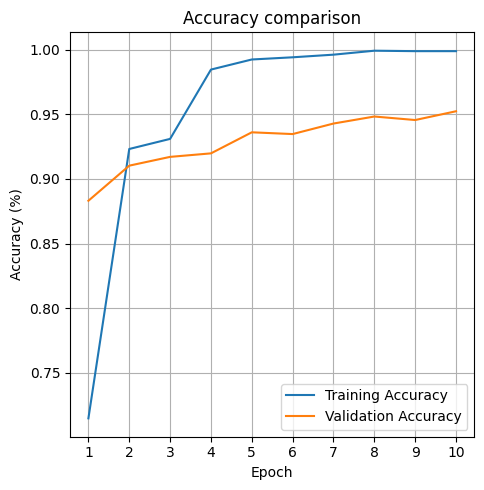

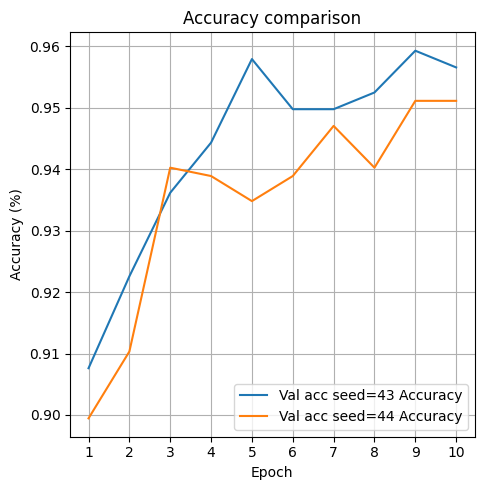

Train/Val size: 2944:736, Iterations per epoch: 92
GPU acceleration enabled: Yes 🚀


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [1/10], Loss: 1.6811, Train Acc: 72.01%, Val Acc: 89.81%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [2/10], Loss: 0.4659, Train Acc: 91.92%, Val Acc: 91.85%
Unfroze layer4 at epoch 3


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [3/10], Loss: 0.2429, Train Acc: 93.17%, Val Acc: 92.80%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [4/10], Loss: 0.0813, Train Acc: 98.27%, Val Acc: 94.02%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [5/10], Loss: 0.0441, Train Acc: 99.15%, Val Acc: 95.24%
Unfroze layer3 at epoch 6


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [6/10], Loss: 0.0246, Train Acc: 99.63%, Val Acc: 94.29%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [7/10], Loss: 0.0152, Train Acc: 99.80%, Val Acc: 94.84%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [8/10], Loss: 0.0133, Train Acc: 99.80%, Val Acc: 94.16%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [9/10], Loss: 0.0110, Train Acc: 99.80%, Val Acc: 94.57%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [10/10], Loss: 0.0081, Train Acc: 99.97%, Val Acc: 94.97%
Train/Val size: 2944:736, Iterations per epoch: 92
GPU acceleration enabled: Yes 🚀


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [1/10], Loss: 2.0802, Train Acc: 63.93%, Val Acc: 84.92%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [2/10], Loss: 0.6938, Train Acc: 91.34%, Val Acc: 89.40%
Unfroze layer4 at epoch 3


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [3/10], Loss: 0.4001, Train Acc: 88.08%, Val Acc: 86.82%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [4/10], Loss: 0.1101, Train Acc: 96.47%, Val Acc: 90.49%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [5/10], Loss: 0.0609, Train Acc: 98.27%, Val Acc: 88.86%
Unfroze layer3 at epoch 6


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [6/10], Loss: 0.3381, Train Acc: 90.01%, Val Acc: 76.36%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [7/10], Loss: 0.1560, Train Acc: 95.41%, Val Acc: 84.78%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [8/10], Loss: 0.0931, Train Acc: 97.38%, Val Acc: 79.21%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [9/10], Loss: 0.0812, Train Acc: 98.00%, Val Acc: 77.99%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [10/10], Loss: 0.0694, Train Acc: 97.89%, Val Acc: 86.41%
Train/Val size: 2944:736, Iterations per epoch: 92
GPU acceleration enabled: Yes 🚀


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [1/10], Loss: 2.0715, Train Acc: 62.50%, Val Acc: 87.77%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [2/10], Loss: 0.6837, Train Acc: 91.78%, Val Acc: 90.49%
Unfroze layer4 at epoch 3


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [3/10], Loss: 0.4141, Train Acc: 87.81%, Val Acc: 86.41%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [4/10], Loss: 0.1118, Train Acc: 97.32%, Val Acc: 90.76%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [5/10], Loss: 0.0545, Train Acc: 98.81%, Val Acc: 88.86%
Unfroze layer3 at epoch 6


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [6/10], Loss: 0.3183, Train Acc: 90.18%, Val Acc: 79.62%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [7/10], Loss: 0.1675, Train Acc: 94.77%, Val Acc: 82.61%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [8/10], Loss: 0.0831, Train Acc: 97.28%, Val Acc: 86.28%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [9/10], Loss: 0.0580, Train Acc: 98.44%, Val Acc: 81.25%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [10/10], Loss: 0.0823, Train Acc: 97.96%, Val Acc: 81.11%
Train/Val size: 2944:736, Iterations per epoch: 92
GPU acceleration enabled: Yes 🚀


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [1/10], Loss: 2.0579, Train Acc: 63.96%, Val Acc: 90.35%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [2/10], Loss: 0.6898, Train Acc: 91.27%, Val Acc: 92.12%
Unfroze layer4 at epoch 3


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [3/10], Loss: 0.4253, Train Acc: 87.60%, Val Acc: 88.45%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [4/10], Loss: 0.1088, Train Acc: 96.71%, Val Acc: 91.03%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [5/10], Loss: 0.0524, Train Acc: 98.64%, Val Acc: 89.95%
Unfroze layer3 at epoch 6


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [6/10], Loss: 0.3245, Train Acc: 90.62%, Val Acc: 81.11%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [7/10], Loss: 0.1661, Train Acc: 94.87%, Val Acc: 83.97%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [8/10], Loss: 0.0881, Train Acc: 97.62%, Val Acc: 80.98%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [9/10], Loss: 0.0520, Train Acc: 98.74%, Val Acc: 83.56%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [10/10], Loss: 0.0757, Train Acc: 97.79%, Val Acc: 83.83%


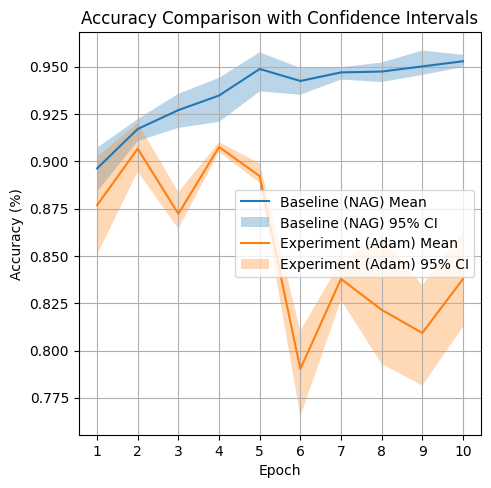

In [2]:
%reload_ext autoreload
%autoreload 2

from determinism import Determinism

determinism = Determinism(seed=42).sow()  # Keep this before any torch import

from training import TrainParams, NagParams, AdamParams
from evaluation import evaluate_test_accuracy_and_misclassified, \
    evaluate_with_train_val_plot, run_with_different_seeds, run_comparison
from run import run

baseline_params = TrainParams(
    seed=determinism.seed,
    batch_size=32,
    architecture="resnet50",
    n_epochs=10,
    optimizer=NagParams(
        learning_rate=0.01,
        weight_decay=1e-4,
        momentum=0.9,
    ),
    freeze_layers=True,
    unfreezing_epochs=(3, 6),
    validation_freq=1,
    time_limit_seconds=None,
    val_acc_target=None,
)

invalidate_cache_entry = False
if invalidate_cache_entry:
    run.call_and_shelve(baseline_params).clear()

# First plot: Training and validation accuracy
print("Training with params:")
print(baseline_params.pprint())
result = run(baseline_params)

print("Training result:")
print(result.pprint())
evaluate_with_train_val_plot(result)

# Second plot: Rerun training multiple times with different seed
run_with_different_seeds(baseline_params, trials=2)

# Third plot: Compare NAG with Adam
experimental_params = baseline_params.copy()
experimental_params.optimizer = AdamParams(
    learning_rate=0.001,
    weight_decay=1e-4,
)

param_sets = {
    "Baseline (NAG)": baseline_params,
    "Experiment (Adam)": experimental_params,
}

run_comparison(param_sets, trials=3)


# Test model

Training with params:
{
  "seed": 42,
  "batch_size": 32,
  "architecture": "resnet50",
  "optimizer": {
    "learning_rate": 0.01,
    "weight_decay": 0.0001,
    "momentum": 0.9,
    "name": "nag"
  },
  "n_epochs": 10,
  "freeze_layers": true,
  "unfreezing_epochs": [3, 6],
  "validation_freq": 1
}
Train/Val size: 2944:736, Iterations per epoch: 92
GPU acceleration enabled: Yes 🚀


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [1/10], Loss: 1.6812, Train Acc: 70.31%, Val Acc: 89.40%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [2/10], Loss: 0.4688, Train Acc: 91.81%, Val Acc: 91.85%
Unfroze layer4 at epoch 3


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [3/10], Loss: 0.2410, Train Acc: 93.31%, Val Acc: 93.34%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [4/10], Loss: 0.0784, Train Acc: 98.03%, Val Acc: 93.21%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [5/10], Loss: 0.0408, Train Acc: 99.22%, Val Acc: 93.75%
Unfroze layer3 at epoch 6


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [6/10], Loss: 0.0320, Train Acc: 99.46%, Val Acc: 94.29%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [7/10], Loss: 0.0159, Train Acc: 99.83%, Val Acc: 93.61%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [8/10], Loss: 0.0148, Train Acc: 99.73%, Val Acc: 94.43%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [9/10], Loss: 0.0102, Train Acc: 99.90%, Val Acc: 94.57%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [10/10], Loss: 0.0126, Train Acc: 99.73%, Val Acc: 94.02%
Test size: 3669


Evaluating: 100%|██████████| 115/115 [00:13<00:00,  8.73it/s]


Final Test Accuracy: 92.10%
Number of misclassified samples: 290


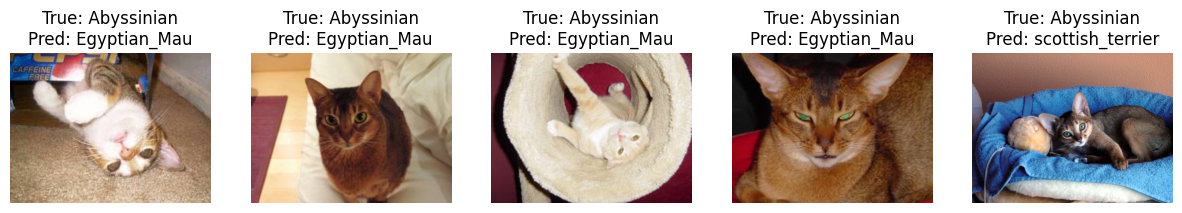

Copied 290 misclassified images to ./misclassified


In [3]:
from run import make_trainer
from torch.utils.data import DataLoader
from training import Trainer
from datasets import load_dataset

training_params = baseline_params

print("Training with params:")
print(training_params.pprint())
trainer, train_loader, val_loader = make_trainer(training_params)
trainer.train(train_loader, val_loader)

test_dataset = load_dataset("test", Trainer.make_transform(training_params))
test_loader = DataLoader(
    test_dataset,
    batch_size=training_params.batch_size,
    shuffle=False,
    num_workers=2,
    worker_init_fn=Determinism.data_loader_worker_init_fn(training_params.seed),
)
print(f"Test size: {len(test_loader.dataset)}")

evaluate_test_accuracy_and_misclassified(trainer, test_loader, test_dataset)
